In [3]:
# File to extract UoA-DR into directories in the ./data folder - categorised into classes for model training. 
# Modify the data_dir so its is in the tree struction of data_dir -> image_class -> image
# UoA-DR: https://figshare.com/s/5011cb600c8bdbc941f1?file=10741045 

import os

# Expect downloaded images from UoA-DR 
data_dir = 'data/UoA-DR/' 

#  X and Y pairs outlined in https://figshare.com/s/5011cb600c8bdbc941f1?file=10910012
classes_dict = {  
    "npdr": {*range(1, 82), *range(83, 95), 130, *range(132, 144), *range(168, 170), *range(171, 175), 179, 193},
    "pdr": {82, *range(95, 101), 131, 167, *range(176, 179), *range(182, 193), *range(194, 201)},
    "healthy": {*range(101, 130), *range(144, 167), 170, 175, *range(180, 182)}
}

image_exts = ['jpeg','jpg', 'bmp', 'png']

# Function to check if a string contains only digits and ends with '.jpg'
def is_retinal_only(file_name):
    return file_name[:-4].isdigit() and file_name.endswith(".jpg")

# Function to find the class of an image given its full filename
def find_class(file_name):
    image_number = file_name[:-4]
    
    for image_class, value_set in classes_dict.items():
        if int(image_number) in value_set:
            print(f"The associated key for {image_number} is: {image_class}")
            break
    else:
        print(f"No associated key found for {image_number}")
    
    return image_class
    
# Create the new folder if it doesn't exist
for image_class in classes_dict.keys():
    new_folder = os.path.join(data_dir, image_class)
    os.makedirs(new_folder, exist_ok=True)

# Modify the data_dir so its is in the tree struction of data_dir -> image_class -> image
for image_folder in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_folder)):
        if is_retinal_only(image):
            image_class = find_class(image)

            # Move the image to the new folder
            original_image_path = os.path.join(data_dir, image_folder, image)
            new_image_path = os.path.join(data_dir, image_class, image)
            os.rename(original_image_path, new_image_path)
            
            print("Original Path:", original_image_path)
            print("New Path:", new_image_path)

The associated key for 37 is: npdr
Original Path: data/UoA-DR/37/37.jpg
New Path: data/UoA-DR/npdr/37.jpg
The associated key for 131 is: pdr
Original Path: data/UoA-DR/131/131.jpg
New Path: data/UoA-DR/pdr/131.jpg
The associated key for 19 is: npdr
Original Path: data/UoA-DR/19/19.jpg
New Path: data/UoA-DR/npdr/19.jpg
The associated key for 198 is: pdr
Original Path: data/UoA-DR/198/198.jpg
New Path: data/UoA-DR/pdr/198.jpg
The associated key for 156 is: healthy
Original Path: data/UoA-DR/156/156.jpg
New Path: data/UoA-DR/healthy/156.jpg
The associated key for 61 is: npdr
Original Path: data/UoA-DR/61/61.jpg
New Path: data/UoA-DR/npdr/61.jpg
The associated key for 84 is: npdr
Original Path: data/UoA-DR/84/84.jpg
New Path: data/UoA-DR/npdr/84.jpg
The associated key for 17 is: npdr
Original Path: data/UoA-DR/17/17.jpg
New Path: data/UoA-DR/npdr/17.jpg
The associated key for 46 is: npdr
Original Path: data/UoA-DR/46/46.jpg
New Path: data/UoA-DR/npdr/46.jpg
The associated key for 132 is: n

In [4]:
# Write the data to a CSV file
import csv
csv_filename = "UoA-DR-labels.csv"
csv_file_path = os.path.join(data_dir, csv_filename)
data_rows = []

# Iterate through the dictionary and create rows
for class_name, values in classes_dict.items():
    for value in values:
        # Initialize the one-hot encoding columns
        one_hot_encoding = {class_keys: 0 for class_keys in classes_dict.keys()}
        one_hot_encoding[class_name] = 1
        
        # Append the row to the data_rows list
        data_rows.append([str(value), class_name, one_hot_encoding["healthy"], one_hot_encoding["npdr"], one_hot_encoding["pdr"]])



with open(csv_file_path, "w", newline="") as csvfile:
    csv_writer = csv.writer(csvfile)
    
    # Write the header row
    csv_writer.writerow(["image number", "class", "healthy", "npdr", "pdr"])
    
    # Write the data rows
    csv_writer.writerows(data_rows)

print("CSV file created:", csv_file_path)


CSV file created: data/UoA-DR/UoA-DR-labels.csv


In [6]:
# Create training and testing folders
import random
from shutil import copyfile
train_dir = os.path.join(data_dir, 'train')
os.makedirs(train_dir, exist_ok=True)
test_dir = os.path.join(data_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

ALL_CLASS_DIR = []

#Under train and validation folder create sub folders for each class
for class_name in classes_dict.keys():
    new_train_class_dir = os.path.join(train_dir, class_name)
    new_test_class_dir = os.path.join(test_dir, class_name)
    os.makedirs(new_train_class_dir, exist_ok=True)
    os.makedirs(new_test_class_dir, exist_ok=True)

    SOURCE = os.path.join(data_dir, class_name)
    TRAIN = os.path.join(train_dir, class_name)
    TEST = os.path.join(test_dir, class_name)

    ALL_CLASS_DIR.append([SOURCE, TRAIN, TEST])


print(ALL_CLASS_DIR)

def split_data(SOURCE, TRAINING, TEST, SPLIT_SIZE):
    files = []
    for image_name in os.listdir(SOURCE):
        file = os.path.join(SOURCE, image_name)
        if os.path.getsize(file) > 0:
            files.append(image_name)
        else:
            print(image_name + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testlength = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    test_set = shuffled_set[training_length:]

    for filename in training_set:
        this_file = os.path.join(SOURCE, filename)
        destination = os.path.join(TRAINING, filename)
        copyfile(this_file, destination)

    for filename in test_set:
        this_file = os.path.join(SOURCE, filename)
        destination = os.path.join(TEST, filename)
        copyfile(this_file, destination)


# Populate training and testing folders with data split from SOURCE for each class
split_size = .85
for class_folders in ALL_CLASS_DIR:
    source, train, test = class_folders
    split_data(source, train, test, split_size)

[['data/UoA-DR/npdr', 'data/UoA-DR/train/npdr', 'data/UoA-DR/test/npdr'], ['data/UoA-DR/pdr', 'data/UoA-DR/train/pdr', 'data/UoA-DR/test/pdr'], ['data/UoA-DR/healthy', 'data/UoA-DR/train/healthy', 'data/UoA-DR/test/healthy']]


Train sizes: {'npdr': 96, 'pdr': 25, 'healthy': 47}
Test sizes: {'npdr': 17, 'pdr': 5, 'healthy': 9}


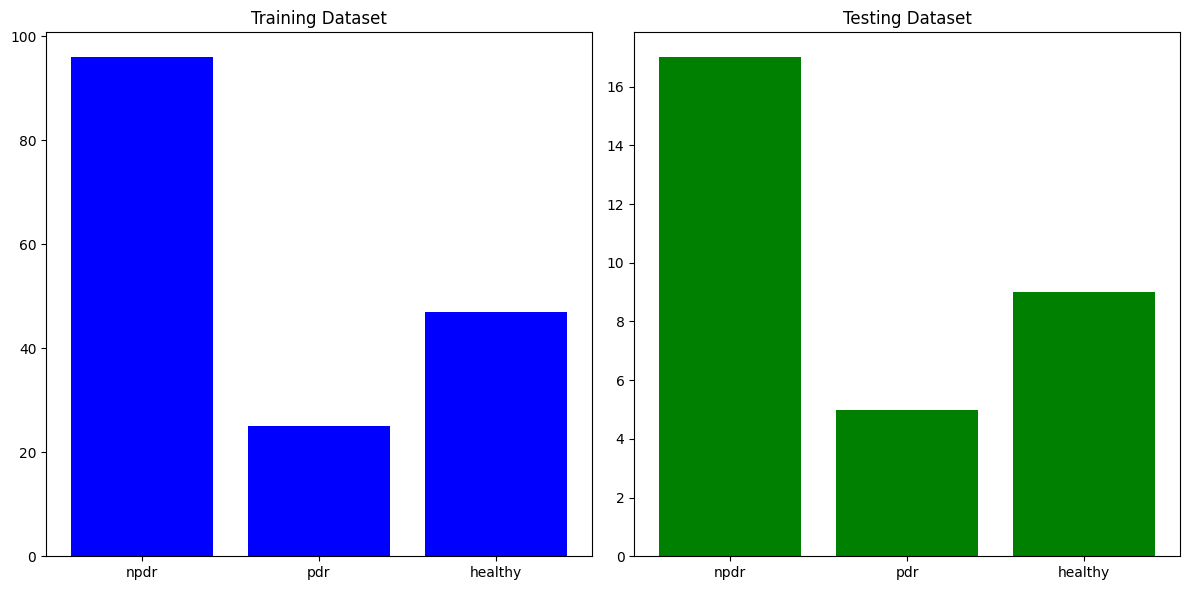

In [15]:
# Plot training and testing split
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
import pathlib

nimgs_train, nimgs_test = {}, {}
# nimgs = {}
for class_folder in classes_dict.keys():
    # nimages = len(os.listdir(train_dir+i+'/'))
    nimgs_train[class_folder] = len(os.listdir(os.path.join(train_dir, class_folder)))
    nimgs_test[class_folder] = len(os.listdir(os.path.join(test_dir, class_folder)))
    # nimages = len(os.listdir(os.path.join(train_dir, class_folder)))
    # print(nimages)
    # nimgs[class_folder]=nimages

print("Train sizes:", nimgs_train)
print("Test sizes:",nimgs_test)

# Create subplots for training and testing dataset distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot training dataset distribution
axes[0].bar(range(len(nimgs_train)), list(nimgs_train.values()), align='center', color='blue')
axes[0].set_xticks(range(len(nimgs_train)))
axes[0].set_xticklabels(list(nimgs_train.keys()))
axes[0].set_title('Training Dataset')

# Plot testing dataset distribution
axes[1].bar(range(len(nimgs_test)), list(nimgs_test.values()), align='center', color='green')
axes[1].set_xticks(range(len(nimgs_test)))
axes[1].set_xticklabels(list(nimgs_test.keys()))
axes[1].set_title('Testing Dataset')

plt.tight_layout()
plt.show()

# plt.figure(figsize=(9, 6))
# plt.bar(range(len(nimgs)), list(nimgs.values()), align='center')
# plt.xticks(range(len(nimgs)), list(nimgs.keys()))
# plt.title('Distribution of different classes in Training Dataset')
# plt.show()